In [16]:
import numpy as np
from scipy.linalg import eigh
import urllib.request
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm 

In [5]:
def load_uci_digits():
    # 数据集URL地址（官网数据）
    base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/"
    files = ["mfeat-fou", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]

    views = []
    for file in ["mfeat-fac", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]:
        url = base_url + file
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8').strip().split('\n')
        view = np.array([list(map(float, line.strip().split())) for line in data])
        view = view[:2000, :]  # 只取前2000个样本（每个类别200个，共10个类别）
        views.append(view)

    return views

# 加载数据
views = list(load_uci_digits())
for idx, view in enumerate(views):
    print(f"View {idx+1} shape:", view.shape)

View 1 shape: (2000, 216)
View 2 shape: (2000, 76)
View 3 shape: (2000, 64)
View 4 shape: (2000, 240)
View 5 shape: (2000, 47)
View 6 shape: (2000, 6)


In [37]:
def single_view_graph_learning(X, c, beta=1.0, iter=100):
    '''
    X: 单视图数据，维度为 (样本数n x 特征维度d)
    c: 聚类簇数
    beta: 正则化参数
    '''
    n = X.shape[0]
    S = np.zeros((n, n))
    Q = np.linalg.qr(np.random.rand(n, c))[0]
    for iter in range(iter):
        for j in range(n):
            q_diff = np.linalg.norm(Q - Q[j, :], axis=1)**2
            s_j = (-q_diff / (2*beta))
            s_j = np.exp(s_j - np.max(s_j))  # 防止数值溢出
            s_j /= np.sum(s_j)
            S[:, j] = s_j
        S_sym = (S + S.T) / 2
        D = np.diag(np.sum(S_sym, axis=1))
        L = D - S_sym
        eigvals, eigvecs = eigh(L, subset_by_index=[0, c-1])
        Q = eigvecs
        eigen_gap = np.sum(eigvals[:c])
        if eigen_gap < 1e-10:
            break

    return S

In [17]:
def global_graph_learning(S_views, c, gamma=1.0, max_iter=50):
    '''
    S_views: list of learned graphs from multiple views (each S is n×n)
    c: 聚类簇数
    gamma: 正则化参数
    '''
    nv = len(S_views)  # 视图数量
    n = S_views[0].shape[0]
    # 初始化权重 w
    w = np.ones((nv, n)) / nv
    # 初始化全局图 A
    A = np.mean(S_views, axis=0)

    for iter_out in tqdm(range(max_iter), desc='Global Graph Learning Progress'):
        # Step 1: 更新 A
        for iter_inner in range(max_iter):
            S_w = np.sum([w[v, :] * S_views[v] for v in range(nv)], axis=0)
            # 更新 A
            for j in range(n):
                # 计算h_j
                D = np.diag(np.sum((A + A.T) / 2, axis=1))
                L_a = D - (A + A.T) / 2
                # 计算h_j
                eigvals, eigvecs = eigh(L_a, subset_by_index=[0, c-1])
                P = eigvecs
                h_j = np.linalg.norm(P - P[j, :], axis=1)**2
                # 更新a_j (与算法1类似)
                a_j = -(gamma/2)*h_j + np.sum([w[v, j]*S_views[v][:,j] for v in range(nv)], axis=0)
                a_j = np.maximum(a_j, 0)
                a_j /= np.sum(a_j) + 1e-12
                A[:, j] = a_j

        # Step 2: 更新P
        D = np.diag(A.sum(axis=1))
        L_a = D - (A + A.T)/2
        eigvals, eigvecs = eigh(L_a, subset_by_index=[0, c-1])
        P = eigvecs

        # 检查收敛条件（是否形成c个连通分量）
        if np.sum(eigvals[:c]) < 1e-8:
            tqdm.write(f"Converged at iteration {iter_out}")
            break

        # Step 3: 更新 w
        for j in range(n):
            Z_j = np.column_stack([A[:, j] - S[:, j] for S in S_views])
            ZTZ = Z_j.T @ Z_j
            # 防止奇异矩阵，添加正则化项
            Z_jTZ_j_reg = Z_j.T @ Z_j + 1e-6 * np.eye(nv)
            w_j = np.linalg.solve(Z_j.T @ Z_j + np.eye(nv)*1e-8, np.ones(nv))
            w_j = np.maximum(w_j, 0)
            w_j /= np.sum(w_j) + 1e-12
            w[:, j] = w_j

    return A


In [19]:
views = load_uci_digits()
X1, X2, X3, X4, X5, X6 = views

In [27]:
S_views = []
for v in range(len(views)):
    S_v = single_view_graph_learning(X=views[v], c=10, beta=1.0)
    S_views.append(S_v)

In [29]:
# 调用之前给出的global_graph_learning函数
A = global_graph_learning(S_views, c=10, gamma=1.0, max_iter=5)

# 检查全局图A的性质
print("Global graph A shape:", A.shape)
print("每列元素是否非负：", np.all(A >= 0))
print("每列和是否为1：", np.allclose(A.sum(axis=0), 1.0))

Global Graph Learning Progress:   0%|          | 0/5 [01:06<?, ?it/s]


KeyboardInterrupt: 

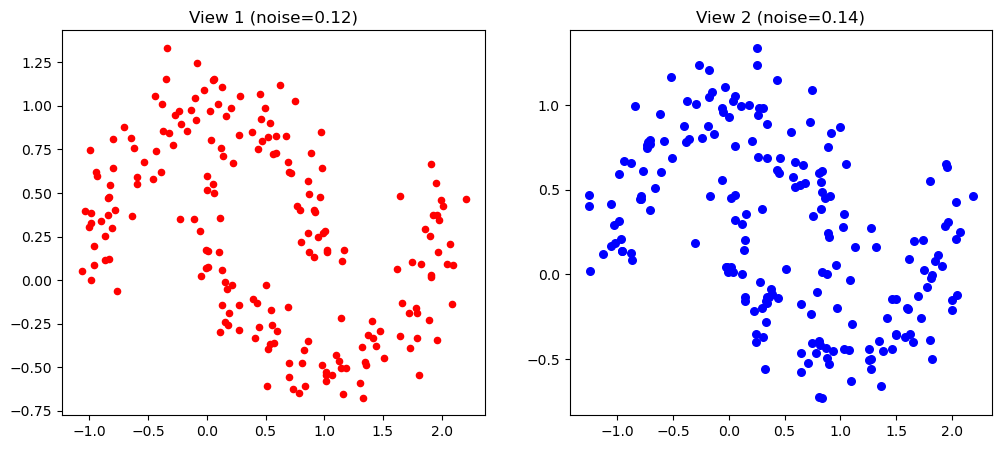

In [21]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

# 生成基础数据
X, labels = make_moons(n_samples=200, noise=0.05, random_state=42)

# 视图1（添加0.12噪声）
np.random.seed(42)
X_view1 = X + 0.12 * np.random.randn(*X.shape)

# 视图2 (噪声更大)
X_view2 = X + 0.14 * np.random.randn(*X.shape)

# 可视化检查
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_view1[:,0], X_view1[:,1], c= 'red', s=20)
axes[0].set_title('View 1 (noise=0.12)')
axes[1].scatter(X_view2[:, 0], X_view2[:, 1], c= 'blue', s=30)
axes[1].set_title('View 2 (noise=0.14)')
plt.show()

In [22]:
S_view1 = single_view_graph_learning(X_view1, c=2, beta=1.0)
S_view2 = single_view_graph_learning(X_view2, c=2, beta=1.0)

In [ ]:
print(S_view1.shape, S_view2.shape) 

(200, 200) (200, 200)


In [31]:
S_views = [S_view1, S_view2]
A = global_graph_learning(S_views, c=2, gamma=1.0, max_iter=50)

print("Global graph shape:", A.shape) # 应为(200, 200)

Global Graph Learning Progress:   0%|          | 0/50 [00:10<?, ?it/s]

Converged at iteration 0
Global graph shape: (200, 200)


In [32]:
import networkx as nx

def get_labels_from_graph(A, threshold=1e-4):
    adjacency_matrix = (A + A.T) / 2
    adjacency_matrix[adjacency_matrix < threshold] = 0
    adjacency_matrix[adjacency_matrix >= threshold] = 1

    G = nx.from_numpy_array(adjacency_matrix)
    components = list(nx.connected_components(G))

    labels_pred = np.zeros(A.shape[0], dtype=int)
    for cluster_id, comp in enumerate(components):
        labels_idx = list(comp)
        labels_pred[labels_idx] = cluster_id

    return labels_pred

# 获得聚类标签（使用你得到的A）
labels_pred = get_labels_from_graph(A)
print("Predicted labels:", labels_pred)

Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


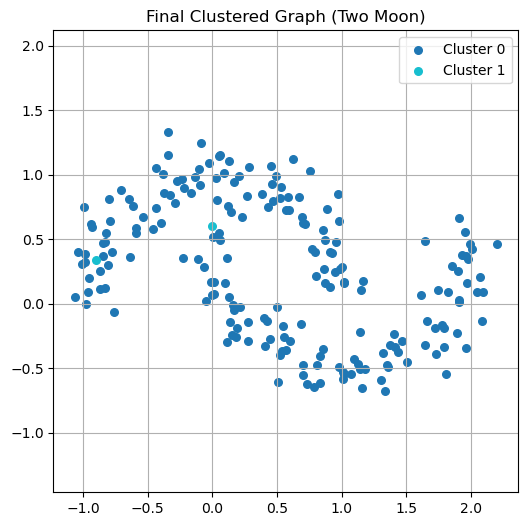

In [33]:
import matplotlib.pyplot as plt

def plot_colored_clusters(X, labels, title='Clustered Graph'):
    plt.figure(figsize=(6,6))
    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

    for i in range(num_clusters):
        plt.scatter(X[labels==i, 0], X[labels==i, 1], s=30, color=colors[i], label=f'Cluster {i}')

    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

# 例如，使用view1的数据点坐标进行绘制
plot_colored_clusters(X_view1, labels_pred, title='Final Clustered Graph (Two Moon)')

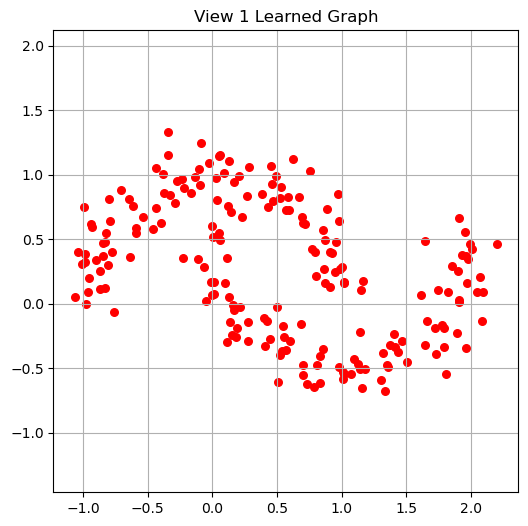

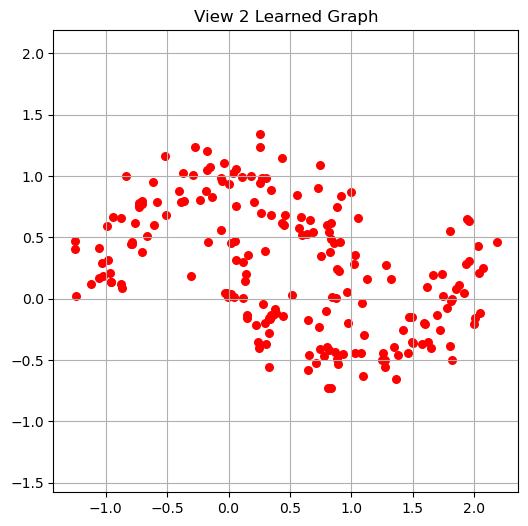

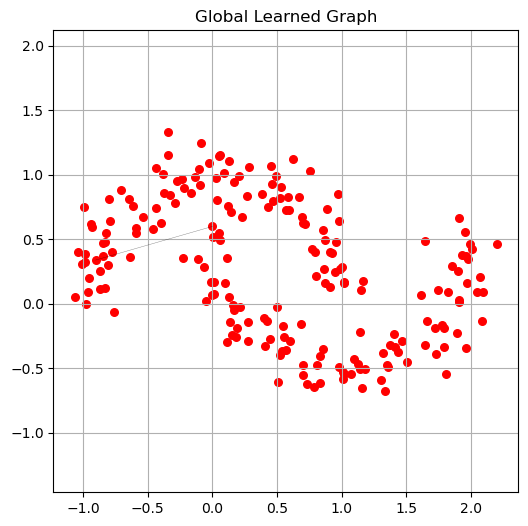

In [25]:
import matplotlib.pyplot as plt

def plot_graph(X, S, title='Graph', threshold=0.02):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c='red', s=30)
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if S[i,j] > threshold or S[j,i] > threshold:
                plt.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], 'k-', linewidth=0.3, alpha=0.5)
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# 视图1 learned graph
plot_graph(X_view1, S_view1, threshold=0.01, title='View 1 Learned Graph')

# 视图2
plot_graph(X_view2, S_view2, threshold=0.01, title='View 2 Learned Graph')

# 全局图用视图1的坐标绘制 (与论文一致)
plot_graph(X_view1, A, threshold=0.02, title='Global Learned Graph')